# Comparison Tables By Metrice Scores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from impyute.imputation.cs import fast_knn
import pickle

# Scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

In [2]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scoring = make_scorer(roc_auc_score)
def gsearch(classifier, X_train, y_train, param_grid, scoring=scoring):
    gs = GridSearchCV(estimator=classifier,
                      param_grid=param_grid, 
                      scoring=scoring,
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

def collect_scores(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
    
    tpr = tp/(tp + fn)
    tnr = tn/(fp + tn)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    plr = tpr/(1 - tnr)
    nlr = (1 - tpr)/tnr
    y_test_size = y_test.shape[0]
    fn = fn/y_test_size
    fp = fp/y_test_size
    return [tpr, tnr, fn, fp, ppv, npv, plr, nlr, auc]

In [3]:
def best_estimator(X, y):
    best_lr, best_svm, best_rf = [0, 0], [0, 0], [0, 0]

    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(n_jobs=-1, random_state=1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True, random_state=1)]])
    rf = RandomForestClassifier(random_state=1, n_jobs=-1)

    lr_grid = [{'clf__C': param_range,
            'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    rf_grid = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}]

    kf = StratifiedKFold(10, random_state=1)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = gsearch(pipe_lr, X_train, y_train, lr_grid)
        svm = gsearch(pipe_svm, X_train, y_train, svm_grid)
        rf_best = gsearch(rf, X_train, y_train, rf_grid)
        if lr[0] > best_lr[0]:
            best_lr[0] = lr[0]
            best_lr[1] = lr
        if svm[0] > best_svm[0]: 
            best_svm[0] = svm[0]
            best_svm[1] = svm
        if rf_best[0] > best_rf[0]: 
            best_rf[0] = rf_best[0]
            best_rf[1] = rf_best
            
    return (best_lr[1][2], best_svm[1][2], best_rf[1][2], (best_lr[1][1], best_svm[1][1], best_rf[1][1]))

In [4]:
def return_confusion(classifiers, X_train, X_test, y_train, y_test):
    confmats = []
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        confmats.append(confmat)
    return confmats

def plot_confusion(classifiers, X_train, X_test, y_train, y_test, title, save=False):
    clf_names = ["LR", "SVM", "RF", "BAGGING"]
    confmats = return_confusion(classifiers, X_train, X_test, y_train, y_test)
    plt.figure(figsize=(6,6))
    for ax_num, cnfm, clf_name in zip([221,222,223,224], confmats, clf_names):
        ax = plt.subplot(ax_num)
        ax.title.set_text(clf_name)

        ax.matshow(cnfm, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(cnfm.shape[0]):
            for j in range(cnfm.shape[1]):
                ax.text(x=j, y=i, s=cnfm[i, j], va='center', ha='center')
        
        plt.xlabel('predicted label')
        plt.ylabel('true label')

    plt.suptitle(title, y=1.05, fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

# Importing Data

In [5]:
data = pd.read_excel("NAFLD with FIB4 and NFS Scores.xlsx").drop(294)
features_df = pd.concat([data.iloc[:,1:-13], data[['FIB-4', 'NFS']]], axis=1)
targets_df = data[['Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)',
                         'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)']]

In [6]:
missing_val_counts = dict(features_df.isnull().sum())

In [7]:
baseline2 = features_df.dropna(axis=1) # shape: (604, 20)

In [8]:
baseline2.columns

Index(['Age', 'Gender (Female=1, Male=2)', 'Height', 'Weight',
       'Body Mass Index', 'Systolic Blood Pressure',
       'Diastolic Blood Pressure', 'Diyabetes Mellitus (No=0, Yes=1)',
       'Hypertension (No=0, Yes=1)', 'Hyperlipidemia (No=0, Yes=1)',
       'Metabolic syndrome (No=0, Yes=1)', 'AST', 'ALT', 'Albumin',
       'Total Cholesterol', 'Leukocyte', 'Hemoglobin', 'Trombosit', 'FIB-4',
       'NFS'],
      dtype='object')

## Baseline (No missed values)

In [9]:
models_4_SF = best_estimator(baseline2.values, targets_df.iloc[:,0].values)
models_4_AF = best_estimator(baseline2.values, targets_df.iloc[:,1].values)

In [10]:
# with open('best_models.db', 'rb') as models:
#     keeping_models = pickle.load(models)
    
#     models_4_SF = keeping_models['0']['SF']
#     models_4_AF = keeping_models['0']['AF']

In [11]:
models_4_AF[3] # best parameters of the models

({'clf__C': 0.001, 'clf__penalty': 'l2'},
 {'clf__C': 100.0, 'clf__kernel': 'rbf'},
 {'bootstrap': True,
  'max_depth': 80,
  'max_features': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 8,
  'n_estimators': 300})

In [12]:
lr_best_sf, svm_best_sf, rf_best_sf = models_4_SF[0], models_4_SF[1], models_4_SF[2]
lr_best_af, svm_best_af, rf_best_af = models_4_AF[0], models_4_AF[1], models_4_AF[2]

In [13]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)

sf_models = [lr_best_sf, svm_best_sf, rf_best_sf, bagging]
af_models = [lr_best_af, svm_best_af, rf_best_af, bagging]

In [14]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
X = baseline2.values

for idx, models in enumerate([sf_models, af_models]):
    if idx == 0: target = "SF"
    else: target = "AF"
    comparison_table.setdefault(target, [])
    for mdl in models:
        avrg = []
        y = targets_df.iloc[:,idx].values
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[target].append(avrg_list)

In [15]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
index1 = pd.MultiIndex.from_tuples([('SIGNIFICANT', 'LR'), ('FIBROSIS', 'SVM'), ('','RandomForest'), ('', 'Bagging')])
sf_table_df = pd.DataFrame(np.array(comparison_table['SF']), index=index1, columns=columns)
sf_table_df

Sensitivity (%)  Specificity (%)     FN     FP  \
SIGNIFICANT LR                       59.0             76.0  0.149  0.151   
FIBROSIS    SVM                      46.0             77.0  0.195  0.149   
            RandomForest             42.0             87.0  0.208  0.081   
            Bagging                  45.0             80.0  0.199  0.130   

                            PPV    NPV    PLR    NLR    AUC  
SIGNIFICANT LR            0.582  0.771  2.652  0.542  0.709  
FIBROSIS    SVM           0.531  0.715  2.267  0.719  0.674  
            RandomForest  0.669  0.729  5.172  0.666  0.746  
            Bagging       0.567  0.720  3.294  0.701  0.702

In [16]:
index2 = pd.MultiIndex.from_tuples([('ADVANCED', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
af_table_df = pd.DataFrame(np.array(comparison_table['AF']), index=index2, columns=columns)
af_table_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
ADVANCED LR                       54.0             84.0  0.083  0.133  0.433   
FIBROSIS SVM                      44.0             91.0  0.101  0.076  0.578   
         RandomForest             18.0             98.0  0.147  0.020  0.550   
         Bagging                  20.0             95.0  0.142  0.043  0.437   

                         NPV    PLR    NLR    AUC  
ADVANCED LR            0.894  3.768  0.549  0.784  
FIBROSIS SVM           0.880  8.840  0.624  0.743  
         RandomForest  0.845  6.780  0.843  0.794  
         Bagging       0.846  5.851  0.843  0.763

### Confusion Matrices

In [17]:
X_train_sf_0, X_test_sf_0, y_train_sf_0, y_test_sf_0 = train_test_split(
    baseline2.values, targets_df.iloc[:,0].values, test_size=0.2, random_state=1, stratify= y)

X_train_af_0, X_test_af_0, y_train_af_0, y_test_af_0 = train_test_split(
    baseline2.values, targets_df.iloc[:,1].values, test_size=0.2, random_state=1, stratify= y)

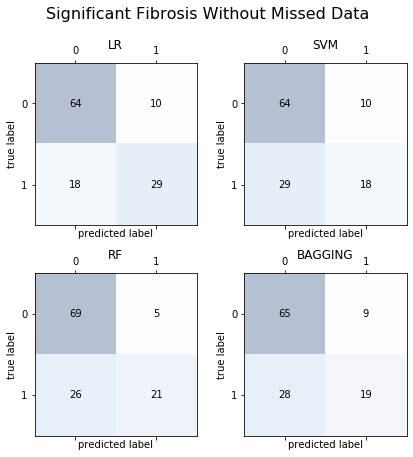

In [18]:
sf_title_0 = "Significant Fibrosis Without Missed Data"
plot_confusion(sf_models, X_train_sf_0, X_test_sf_0, y_train_sf_0, y_test_sf_0, sf_title_0, save=False)

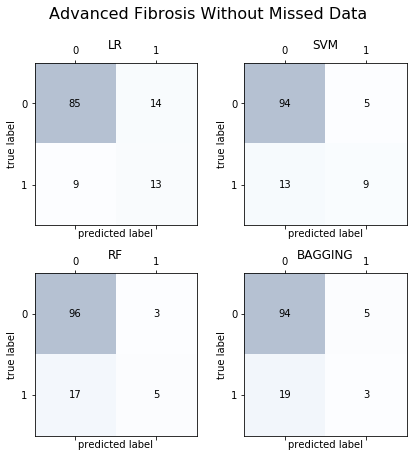

In [19]:
af_title_0 = "Advanced Fibrosis Without Missed Data"
plot_confusion(af_models, X_train_af_0, X_test_af_0, y_train_af_0, y_test_af_0, af_title_0, save=False)

## 25% Threshold

In [20]:
missing_data_percentages = features_df.isnull().mean()
threshold_25_df = features_df.iloc[:, missing_data_percentages.values < 0.25]
knn_25 = fast_knn(threshold_25_df.values, k=30) # shape: (604, 37)

In [21]:
models_25_SF = best_estimator(knn_25, targets_df.iloc[:,0].values)
models_25_AF = best_estimator(knn_25, targets_df.iloc[:,1].values)

In [22]:
# with open('best_models.db', 'rb') as models:
#     keeping_models = pickle.load(models)
    
#     models_25_SF = keeping_models['25']['SF']
#     models_25_AF = keeping_models['25']['AF']

In [23]:
models_25_AF[3] # best parameters of the models

({'clf__C': 0.001, 'clf__penalty': 'l2'},
 {'clf__C': 100.0, 'clf__kernel': 'sigmoid'},
 {'bootstrap': True,
  'max_depth': 80,
  'max_features': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 10,
  'n_estimators': 1000})

In [24]:
lr_best_sf_25, svm_best_sf_25, rf_best_sf_25 = models_25_SF[0], models_25_SF[1], models_25_SF[2]
lr_best_af_25, svm_best_af_25, rf_best_af_25 = models_25_AF[0], models_25_AF[1], models_25_AF[2]

In [25]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)

sf_25_models = [lr_best_sf_25, svm_best_sf_25, rf_best_sf_25, bagging]
af_25_models = [lr_best_af_25, svm_best_af_25, rf_best_af_25, bagging]

In [26]:
comparison_table_25 = {}
kf = StratifiedKFold(10, random_state=1)
X = knn_25

for idx, models in enumerate([sf_25_models, af_25_models]):
    if idx == 0: target = "SF"
    else: target = "AF"
    comparison_table_25.setdefault(target, [])
    for mdl in models:
        avrg = []
        y = targets_df.iloc[:,idx].values
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table_25[target].append(avrg_list)

In [27]:
index3 = pd.MultiIndex.from_tuples([('SIGNIFICANT', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
sf_table_25_df = pd.DataFrame(np.array(comparison_table_25['SF']), index=index3, columns=columns)
sf_table_25_df

Sensitivity (%)  Specificity (%)     FN     FP  \
SIGNIFICANT LR                       59.0             75.0  0.147  0.162   
FIBROSIS    SVM                      48.0             72.0  0.189  0.177   
            RandomForest             39.0             86.0  0.220  0.089   
            Bagging                  40.0             80.0  0.218  0.126   

                            PPV    NPV    PLR    NLR    AUC  
SIGNIFICANT LR            0.562  0.770  2.495  0.549  0.712  
FIBROSIS    SVM           0.495  0.710  1.877  0.743  0.657  
            RandomForest  0.606  0.716  3.352  0.714  0.735  
            Bagging       0.540  0.702  2.438  0.762  0.694

In [28]:
index4 = pd.MultiIndex.from_tuples([('ADVANCED', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
af_table_25_df = pd.DataFrame(np.array(comparison_table_25['AF']), index=index4, columns=columns)
af_table_25_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
ADVANCED LR                       62.0             84.0  0.068  0.136  0.464   
FIBROSIS SVM                      36.0             85.0  0.116  0.126  0.334   
         RandomForest             14.0             98.0  0.154  0.013  0.713   
         Bagging                  27.0             96.0  0.131  0.037  0.642   

                         NPV    PLR    NLR    AUC  
ADVANCED LR            0.911  4.248  0.453  0.794  
FIBROSIS SVM           0.859  2.546  0.756  0.672  
         RandomForest  0.841  7.485  0.872  0.798  
         Bagging       0.858  7.129  0.760  0.747

### Confusion Matrices

In [29]:
X_train_sf_25, X_test_sf_25, y_train_sf_25, y_test_sf_25 = train_test_split(
    knn_25, targets_df.iloc[:,0].values, test_size=0.2, random_state=1, stratify=y)

X_train_af_25, X_test_af_25, y_train_af_25, y_test_af_25 = train_test_split(
    knn_25, targets_df.iloc[:,1].values, test_size=0.2, random_state=1, stratify=y)

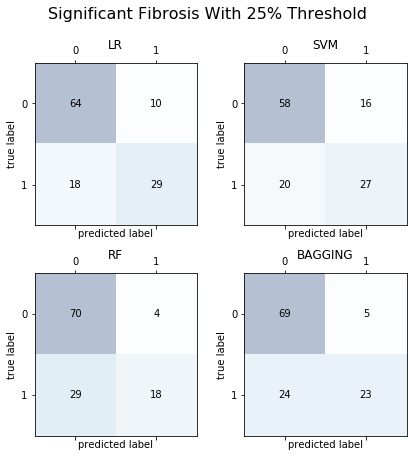

In [30]:
sf_title_25 = "Significant Fibrosis With 25% Threshold"
plot_confusion(sf_25_models, X_train_sf_25, X_test_sf_25, y_train_sf_25, y_test_sf_25, sf_title_25, save=False)

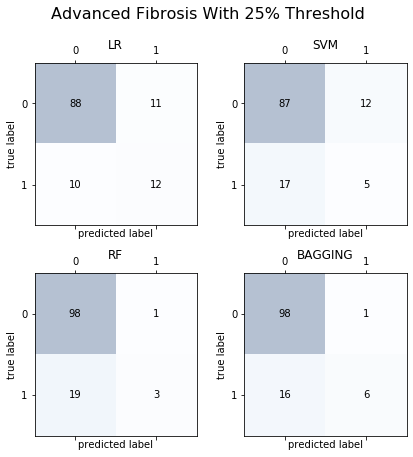

In [31]:
af_title_25 = "Advanced Fibrosis With 25% Threshold"
plot_confusion(af_25_models, X_train_af_25, X_test_af_25, y_train_af_25, y_test_af_25, af_title_25, save=False)

## Keeping Models In The Storage

In [32]:
keep_models = {'0':{'SF':models_4_SF, 'AF':models_4_AF},
               '25':{'SF':models_25_SF, 'AF':models_25_AF}}
with open('best_models_with_additional_features.db','wb') as models:
    pickle.dump(keep_models, models)

In [33]:
# with open('models.db', 'rb') as models:
#     keeping_models = pickle.load(models)

In [34]:
# from pandas.plotting import table

# tables = [sf_table_df, af_table_df, sf_table_25_df, af_table_25_df]
# table_names = ['sf_table.png', 'af_table.png', 'sf_25_table.png', 'af_25_table.png']
# for tbl, name in zip(tables, table_names):
#     ax = plt.subplot(111, frame_on=False) # no visible frame
#     ax.xaxis.set_visible(False)  # hide the x axis
#     ax.yaxis.set_visible(False)  # hide the y axis

#     table(ax, tbl)
#     plt.savefig(name, dpi=600, bbox_inches='tight')